In [2]:
from collections import defaultdict
import json
import glob
import os
import sys
from typing import Tuple

import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

from source import load_avenio_files
from fragment_count.utils import load_samples_as_data_frame
from fragment_count.views import plot_distribution_comparison, plot_distribution

In [3]:
patient_mutations, clinical_data = load_avenio_files()

In [4]:
respond = clinical_data['response_grouped'] == 'responder (pr+cr)'
response_id = clinical_data[respond].index
non_response_id = clinical_data[~respond].index

In [5]:
response_samples = []
non_response_samples = []

for ptid in response_id:
    response_samples += glob.glob(f'fragment_count/output/tumor_derived/{ptid}*.json')
    
for ptid in non_response_id:
    non_response_samples += glob.glob(f'fragment_count/output/tumor_derived/{ptid}*.json')

In [8]:
resp_normal, resp_var = load_samples_as_data_frame(response_samples)
non_resp_normal, non_resp_var = load_samples_as_data_frame(non_response_samples)

In [10]:
def pool(df):
    return df.groupby("length (bp)").sum().sum(axis=1).astype(int)

In [21]:
resp_normal.sum(axis=1)

sample  length (bp)
951_1   1              0.0
        2              0.0
        3              0.0
        4              0.0
        5              0.0
                      ... 
7184_0  877            0.0
        878            0.0
        879            0.0
        880            0.0
        881            0.0
Length: 79290, dtype: float64

In [32]:
def plot_distribution(seq, label=None, with_peaks=True):
    seq_mean = seq.groupby('length (bp)').mean()
    distribution = seq_mean / sum(seq_mean)
    distribution_std = seq.groupby('length (bp)').std() / sum(seq_mean)
    fragment_window = [80, 400]
    
    distribution.plot(label=label, zorder=0)
    upper_bound = distribution + distribution_std
    lower_bound = distribution - distribution_std
    upper_bound.plot()
    lower_bound.plot()
#     plt.fill_between(distribution_std.index, distribution + distribution_std, distribution - distribution_std)
    
#     distribution = seq.copy() / sum(seq)
#     distribution.plot(label=label, zorder=0)
    plt.xlim(fragment_window)

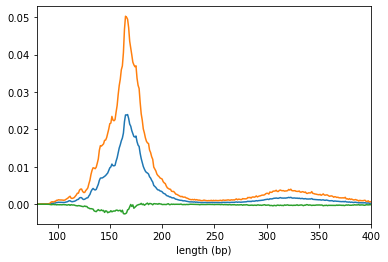

In [33]:
plot_distribution(resp_normal.sum(axis=1))

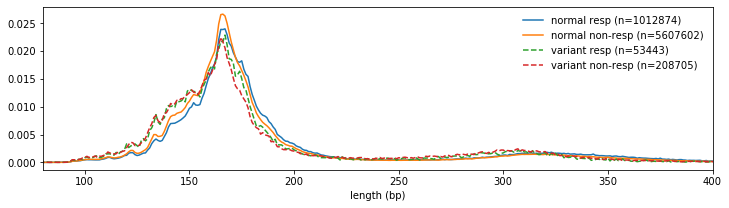

In [14]:
plt.figure(figsize=(12,3))
figure_labels = {
    'resp_normal': f'normal resp (n={pool(resp_normal).sum()})',
    'non_resp_normal': f'normal non-resp (n={pool(non_resp_normal).sum()})',
    'resp_variant': f'variant resp (n={pool(resp_var).sum()})',
    'non_resp_variant': f'variant non-resp (n={pool(non_resp_var).sum()})',
}
with mpl.rc_context(rc={'lines.linestyle':'-'}):
    plot_distribution(
        pool(resp_normal), 
        label=figure_labels['resp_normal'], 
        with_peaks=False,
    )
    plot_distribution(
        pool(non_resp_normal), 
        label=figure_labels['non_resp_normal'], 
        with_peaks=False,
    )
    
# with plt.style.context('linestyle'):
with mpl.rc_context(rc={'lines.linestyle':'--'}):
    plot_distribution(
        pool(resp_var), 
        label=figure_labels['resp_variant'], 
        with_peaks=False,
    )
    plot_distribution(
        pool(non_resp_var), 
        label=figure_labels['non_resp_variant'], 
        with_peaks=False,
    )
    plt.legend(frameon=False)
plt.savefig('figs/distributions_with_response.png')

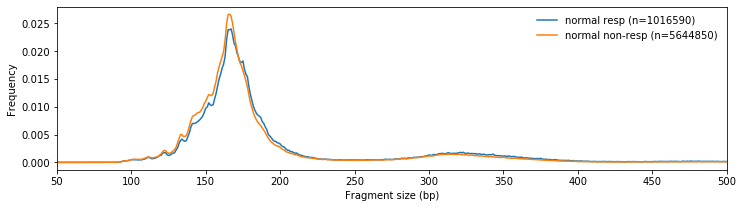

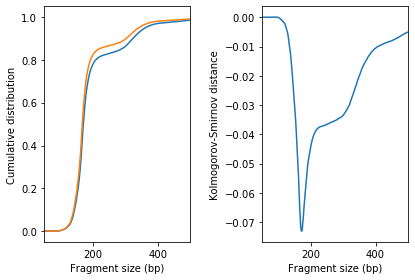

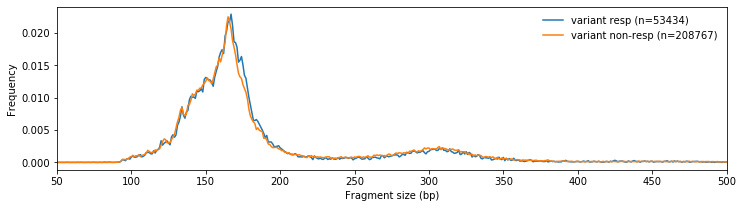

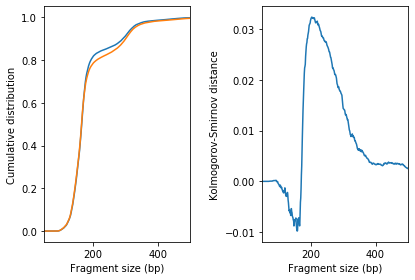

In [12]:
plt.figure(figsize=(12,3))
plot_distribution_comparison(
    pool(resp_normal).sum(axis=1), 
    non_resp_normal.sum(axis=1),
    labels=[figure_labels['resp_normal'], figure_labels['non_resp_normal']],
    filename_suffix='response_normal',
)
plt.savefig('figs/normal_response.png')
plt.figure(figsize=(12,3))
plot_distribution_comparison(
    resp_var.sum(axis=1), 
    non_resp_var.sum(axis=1),
    labels=[figure_labels['resp_variant'], figure_labels['non_resp_variant']],
    filename_suffix='response_variant',
)
plt.savefig('figs/variant_response.png')